Our libraries and imports:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, label_binarize
from sklearn.multiclass import OneVsRestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import label_binarize
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, train_test_split, KFold, GridSearchCV ,StratifiedKFold, learning_curve

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline

# Dataset description

In [2]:
df = pd.read_csv("NHANES_age_prediction.csv")
df.head()

,SEQN,age_group,RIDAGEYR,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN
0,73564.0,Adult,61.0,2.0,2.0,35.7,110.0,2.0,150.0,14.91
1,73568.0,Adult,26.0,2.0,2.0,20.3,89.0,2.0,80.0,3.85
2,73576.0,Adult,16.0,1.0,2.0,23.2,89.0,2.0,68.0,6.14
3,73577.0,Adult,32.0,1.0,2.0,28.9,104.0,2.0,84.0,16.15
4,73580.0,Adult,38.0,2.0,1.0,35.9,103.0,2.0,81.0,10.92


In [3]:
df.describe()

,SEQN,RIDAGEYR,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN
count,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000
mean,78691.853819,41.795874,1.511414,1.822651,27.955180,99.553117,2.016242,114.978929,11.834794
std,2921.365151,20.156111,0.499979,0.398918,7.248962,17.889834,0.185556,47.061239,9.718812
min,73564.000000,12.000000,1.000000,1.000000,14.500000,63.000000,1.000000,40.000000,0.140000
25%,76171.750000,24.000000,1.000000,2.000000,22.800000,91.000000,2.000000,87.000000,5.860000
50%,78749.000000,41.000000,2.000000,2.000000,26.800000,97.000000,2.000000,105.000000,9.040000
75%,81213.500000,58.000000,2.000000,2.000000,31.200000,104.000000,2.000000,130.000000,14.440000
max,83727.000000,80.000000,2.000000,7.000000,70.100000,405.000000,3.000000,604.000000,102.290000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SEQN       2278 non-null   float64
 1   age_group  2278 non-null   object 
 2   RIDAGEYR   2278 non-null   float64
 3   RIAGENDR   2278 non-null   float64
 4   PAQ605     2278 non-null   float64
 5   BMXBMI     2278 non-null   float64
 6   LBXGLU     2278 non-null   float64
 7   DIQ010     2278 non-null   float64
 8   LBXGLT     2278 non-null   float64
 9   LBXIN      2278 non-null   float64
dtypes: float64(9), object(1)
memory usage: 178.1+ KB


In [5]:
print("\nMissing Values:\n", df.isnull().sum())
print("\nDuplicate Rows:", df.duplicated().sum())


Missing Values:
 SEQN         0
age_group    0
RIDAGEYR     0
RIAGENDR     0
PAQ605       0
BMXBMI       0
LBXGLU       0
DIQ010       0
LBXGLT       0
LBXIN        0
dtype: int64

Duplicate Rows: 0


* Our dataset is based on data from the National Health and Nutrition Examination Survey, it contains medical tests of participants and based on them we aim to predict the `age_group` of the participant.
* Overall there are 2278 instances, no null values and duplicate rows.
* All features are type float64, but the `age_group` is category.

# Transforming the dataset

### Our Feature Engineering:
##### Creating "Young" group and Dropping Age column
If we keep the age column in the dataet, models will use it to guess the answer, it leads to **data leakage** because these models seem pretty accurate at training but in real cases they will fail the performance on new data.

In [6]:
df['age_group'] = df.apply(lambda row: 'Young' if 12 <= row['RIDAGEYR'] <= 25 else row['age_group'], axis=1)

df = df.drop('RIDAGEYR', axis=1)

#### Renaming the columns for clearer understanding of data

In [7]:
df.rename(columns={
    'SEQN': 'ID',
    'RIAGENDR': 'gender',
    'PAQ605': 'physical_activity',
    'BMXBMI': 'bmi',
    'LBXGLU': 'glucose',
    'DIQ010': 'diabetes_status',
    'LBXGLT': 'glucose_tolerance',
    'LBXIN': 'insulin'
}, inplace=True)

#### Converting age_group into numeric value for future using

In [8]:
categories_order = [['Young', 'Adult', 'Senior']]
ordinal_encoder = OrdinalEncoder(categories=categories_order)
df['age_group'] = ordinal_encoder.fit_transform(df[['age_group']])

#### Choosing color palette

In [9]:
sns.set_palette("deep")

# Data Analysis
##### Our new head:

In [10]:
df.head()

,ID,age_group,gender,physical_activity,bmi,glucose,diabetes_status,glucose_tolerance,insulin
0,73564.0,1.0,2.0,2.0,35.7,110.0,2.0,150.0,14.91
1,73568.0,1.0,2.0,2.0,20.3,89.0,2.0,80.0,3.85
2,73576.0,0.0,1.0,2.0,23.2,89.0,2.0,68.0,6.14
3,73577.0,1.0,1.0,2.0,28.9,104.0,2.0,84.0,16.15
4,73580.0,1.0,2.0,1.0,35.9,103.0,2.0,81.0,10.92


### Distrubution graphs

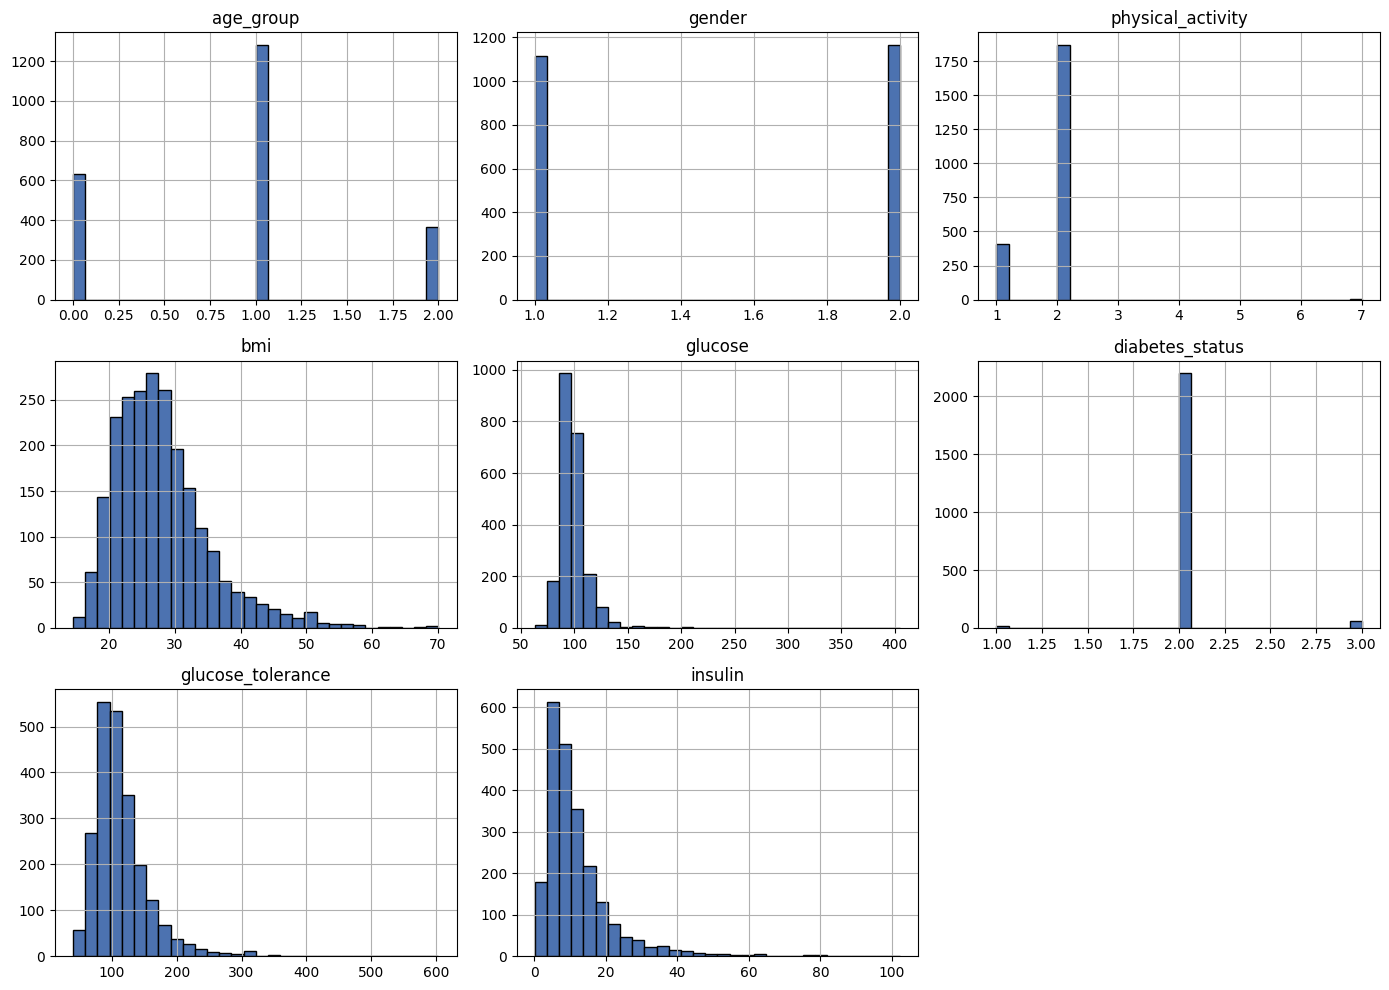

In [11]:
plot_columns = df.drop(columns='ID').columns
df[plot_columns].hist(figsize=(14, 10), bins=30, edgecolor='black')
plt.tight_layout()
plt.show()

* `bmi`, `glucose`, `glucose_tolerance`, and `insulin` have almost the same distributions because they depend from each other. And all of the high counts are in the middle, it means most of the participants have normal indicators of these tests.
* Distribution of `physical_activity` shows that most of the participants do not excercise or do sports.
* Distribution of `diabetes_status` tells us that almost all of the participants do not have diabetes.
* Distribution of `age_group` shows that most of the participants are in the Adult age group.

### Correlation map

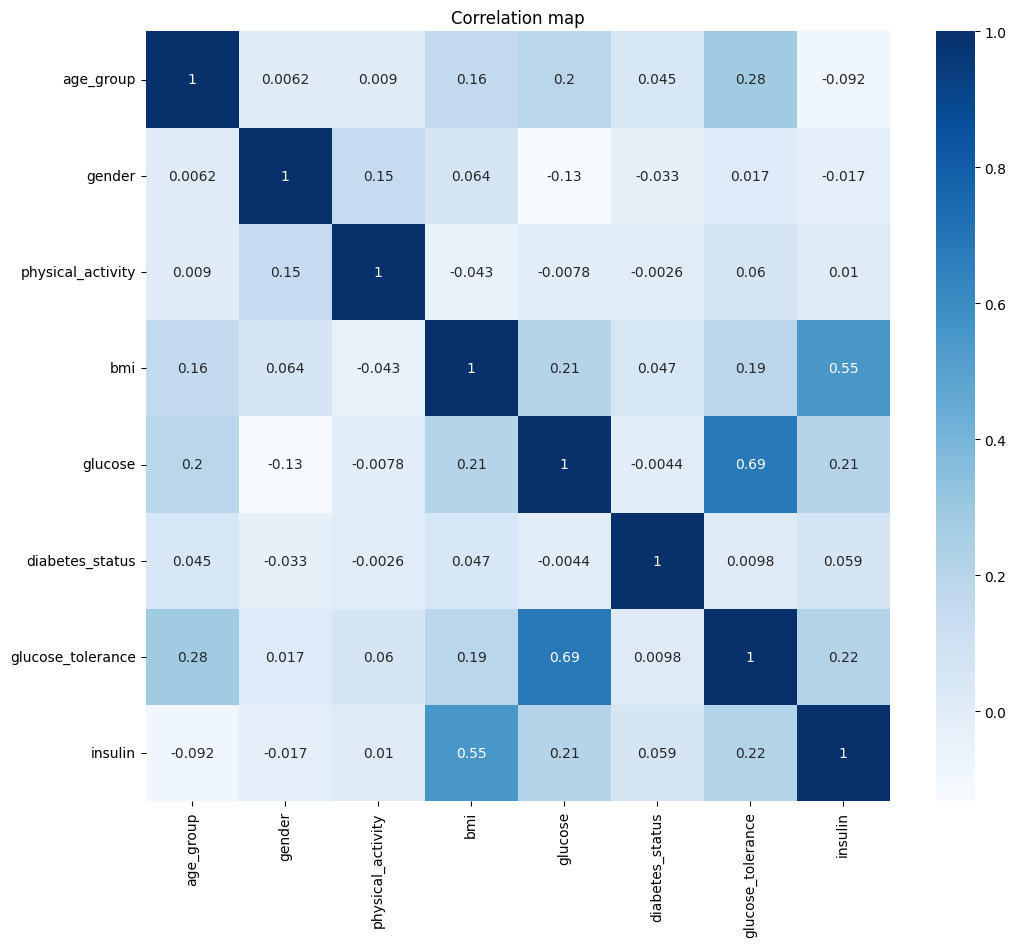

In [12]:
corr= df[plot_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap="Blues")
plt.title("Correlation map")
plt.show()

* On the correlation map we can see high correlation between `glucose` and `glucose_tolerance` **(0.69)**, `bmi` and `insulin` **(0.55)**. First one is because if people have high glucose it means that they have poor glucose tolerance, the second tells us that heavier people tend to have higher insulin.
* Medium **(0.21),(0.19)** correlation of `bmi` with `glucose` and `glucose_torelance` - weight effect on glucose levels; and at the same level **(0.19),(0.16)** correlation of `age_group` between `glucose` and `bmi`, probably because olderly people have higher weight and glucose level.
* Also medium correlation between `age_group` and `glucose_level` **(0.28)** because glucose processing changes with age
* No strong correlations with `age_group` `physical_activity`, `diabetes_status`, `gender` are seen, because they are more **categorical variable**.

### Pair plots for `age_group` and numerical values

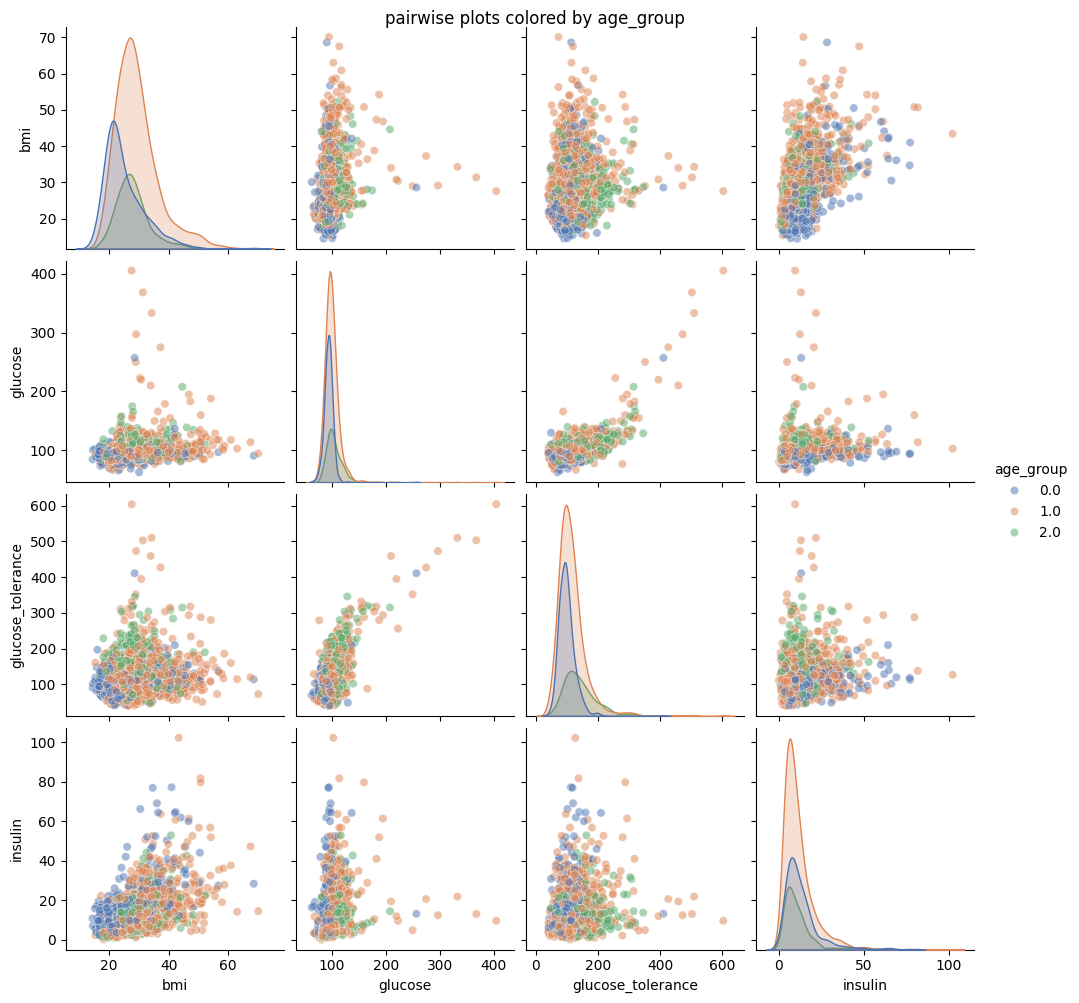

In [13]:
sns.pairplot(
    df,
    vars=['bmi', 'glucose', 'glucose_tolerance', 'insulin'],
    hue='age_group',
    palette='deep',
    plot_kws={'alpha': 0.5}
)
plt.suptitle("pairwise plots colored by age_group", y=1)
plt.show()

* We used **pair plots** to see more detailed correlation between all numerical values, but most important to watch the correlation of `age_group` with them, figure out will they be helpful to predict `age_group` and which variable pairs are most improtant for that.
* `bmi` is bigger in younger and adult groups and smaller in senior; `glucose` and `glucose_tolerance` show increas with `age_group`, while `insulin` levels decrease.
* From this plots we found out that these values are helpful for `age_group` prediction because they reflect changes that occur with aging. `insulin` can help improve predictions, especially when combined with other values and `glucose` and `glucose_tolerance` are most useful because they show upward trends with age.

### Count plots for `age_group` and categorical values

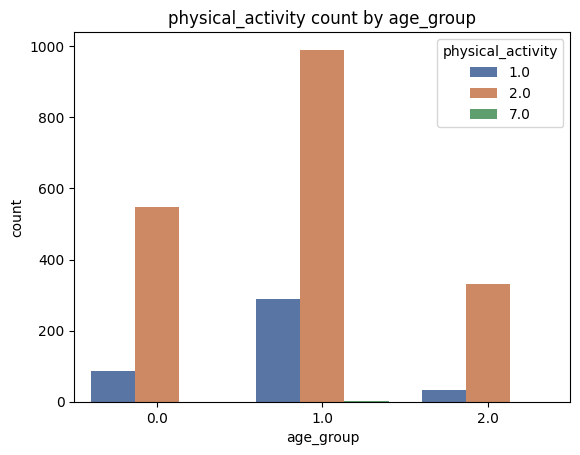

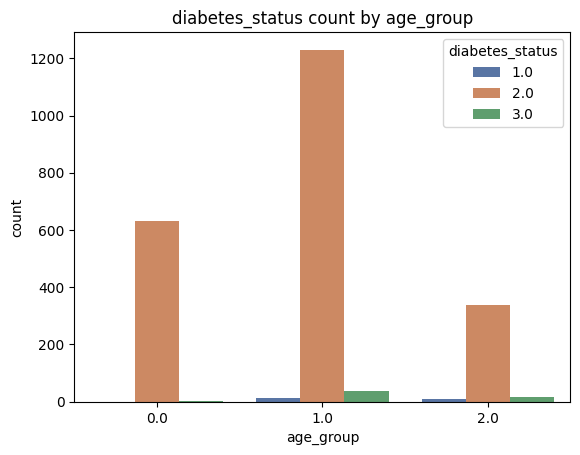

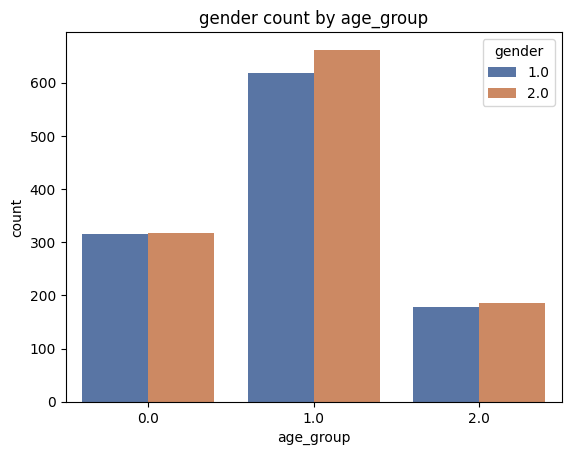

In [14]:
def countplot(df, cols):
    import seaborn as sns
    import matplotlib.pyplot as plt

    for col in cols:
        sns.countplot(x='age_group', hue=col, data=df, palette='deep')
        plt.title(f'{col} count by age_group')
        plt.legend(title=col)
        plt.show()

countplot(df, ['physical_activity', 'diabetes_status', 'gender'])

* We used **count plots** with the same main reason - to see what values will be more helpful to predict `age_group`.
* And from these plots we see that `diabetes_status` is clearly related to age. Most participants from young group don’t have diabetes and older groups have not a lot of cases too, but more. This makes it a good feature for predicting `age_group`. `physical_activity` is the same across age groups, but young group slightly more active. `gender` is queal on all age groups.

### Checking and dropping outliers

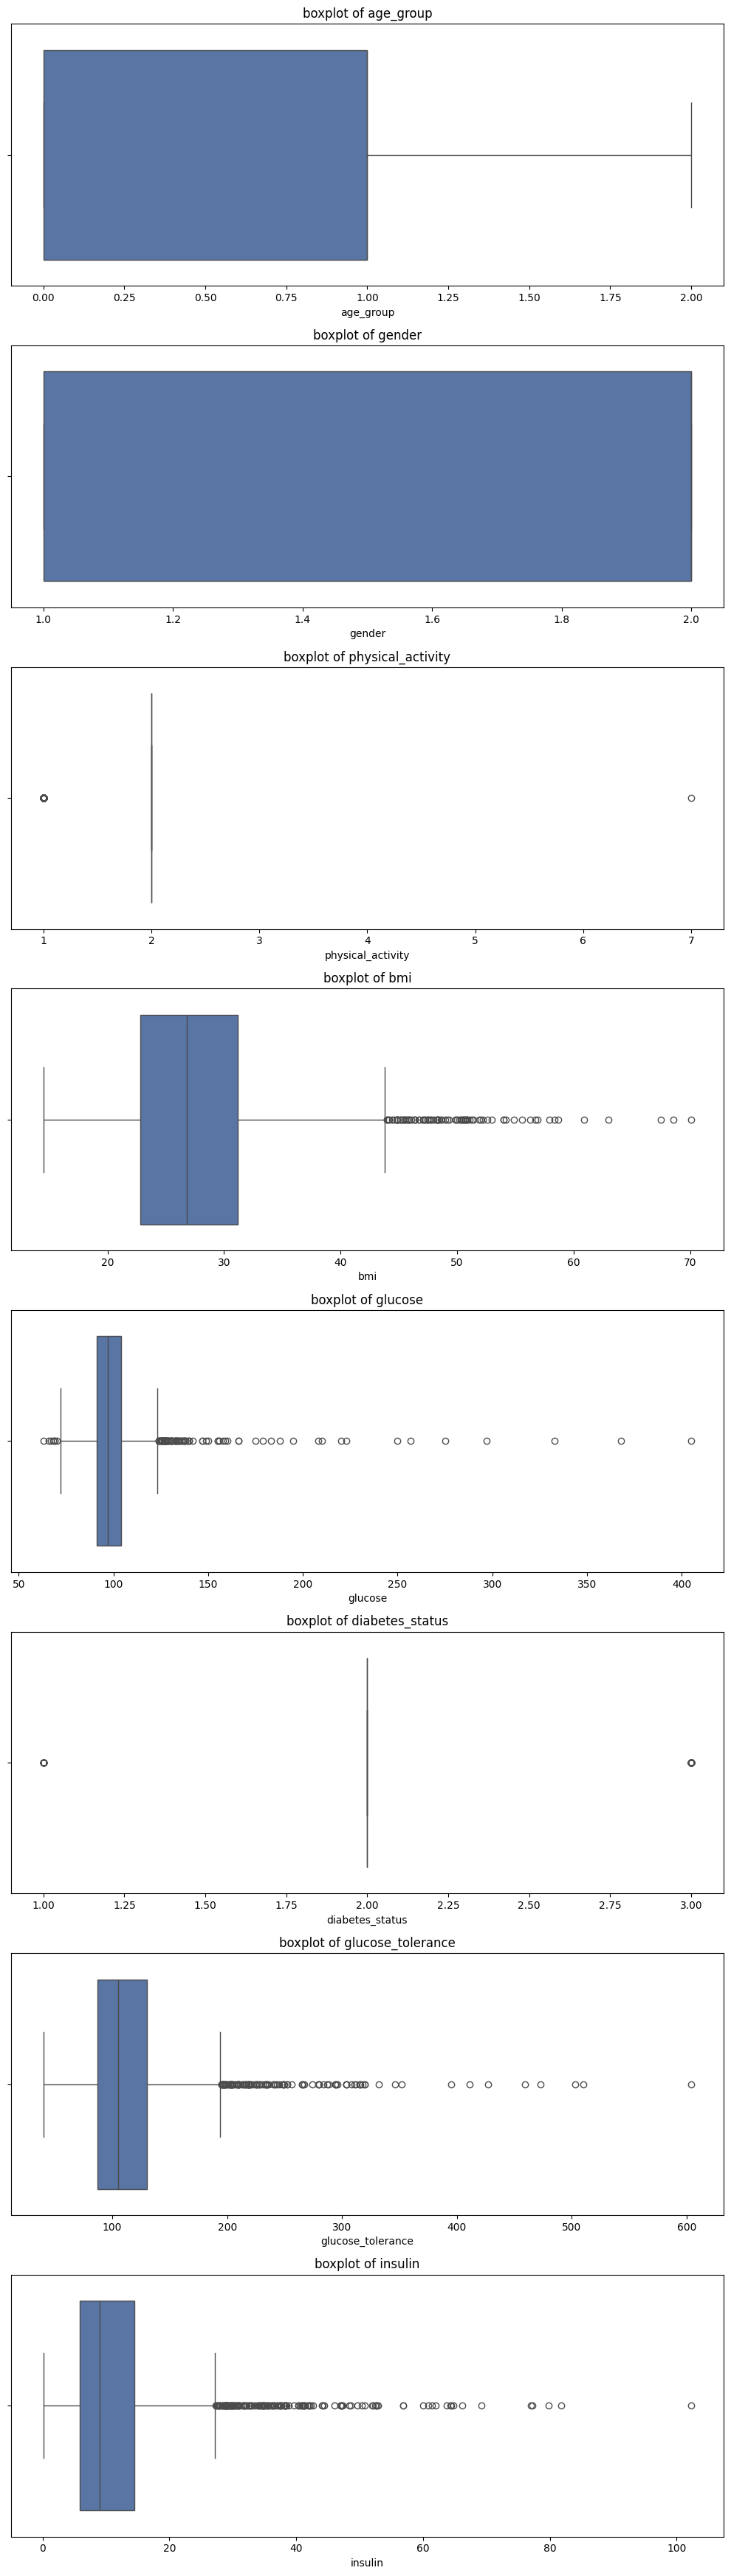

In [15]:
def check_outliers(df):
    fig, axs = plt.subplots(len(df[plot_columns].columns), 1, figsize=(10, 35))
    for i, col in enumerate(df[plot_columns].columns):
        sns.boxplot(x=df[col], ax=axs[i])
        axs[i].set_title(f'boxplot of {col}')
    plt.tight_layout()
    plt.show()

check_outliers(df)

* From the investigation that we have done before, we can say that the `glucose`, `glucose_tolerance`,`insulin` and `diabetes_status` values are very important to prediction of `age_group`, and their outliers can indicate important health conditions that vary across age groups. So we decided to keep them.

In [16]:
def drop_outliers(df, columns):
    exclude = ['glucose', 'glucose_tolerance', 'diabetes_status', 'insulin']
    for col in columns:
        if col not in exclude:
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
            df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

num_cols = df.select_dtypes(include=np.number).columns

df = drop_outliers(df, num_cols)

### Data Scaling

In [17]:
scaler = StandardScaler()
# df_scaled = df.copy()
# df_scaled[num_cols] = scaler.fit_transform(df_scaled[num_cols])
values_to_remove = ['age_group', 'gender', 'physical_activity', 'diabetes_status']
num_cols = num_cols[~num_cols.isin(values_to_remove)]
df[num_cols] = scaler.fit_transform(df[num_cols])

#### Splitting data into input features(X) and target variable(y).

In [18]:
X = df.drop(columns = 'age_group')
y = df['age_group']
df.head()

,ID,age_group,gender,physical_activity,bmi,glucose,diabetes_status,glucose_tolerance,insulin
0,-1.751318,1.0,2.0,2.0,1.502520,0.585635,2.0,0.706930,0.426186
1,-1.749950,1.0,2.0,2.0,-1.139604,-0.542267,2.0,-0.741119,-0.869356
2,-1.747215,0.0,1.0,2.0,-0.642062,-0.542267,2.0,-0.989356,-0.601111
3,-1.746874,1.0,1.0,2.0,0.335867,0.263377,2.0,-0.658374,0.571437
5,-1.745506,1.0,1.0,2.0,-0.573435,0.585635,2.0,-0.327391,-0.608139


# Model training and evaluation

1. Take models and train on X_train, y_train
2. Predict age_group
3. Plot metrics like accuracy_score, confussion_matrix, etc.
4. Tune hyperparameters of the models using tune_parameters.

In [19]:
def checkForOutliers(df):
    fig, axs = plt.subplots(len(df.columns),1,dpi=95, figsize=(7,30))
    axs = np.atleast_1d(axs) 
    for i, col in enumerate(df.columns):
        axs[i].boxplot(df[col], vert=False)
        axs[i].set_ylabel(col)
    plt.show()

def dropOutliers(df, drop_list):
    for col in drop_list:
        q1, q3 = np.percentile(df[col], [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)
        clean_data = df[(df[col] > lower_bound) 
                        & (df[col] < upper_bound)]
        df = clean_data
    return df

# function to tune hyperparameters of a selected model
# how to write param_grid
param_grid = {
    'classification__penalty': ['l1', 'l2', 'elasticnet', None],
    'classification__max_iter': [100, 200, 500],
    'classification__solver': ['lbfgs', 'liblinear', 'newton-cg', 'saga'],
    'classification__multi_class': ['auto', 'ovr', 'multinomial']
}

def tune_hyperparams(model, param_grid, X_train, y_train):
    rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(10), scoring='roc_auc_ovr')
    pipeline = Pipeline([
        ('feature_selection', rfecv),
        ('classification', model)
    ])
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=StratifiedKFold(10), scoring='roc_auc_ovr', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)

def train_predict_evaluate(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=np.nan, average='micro')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    print("\nModel:", str(model))
    print("| Accuracy score:", accuracy)
    print("| Precision score:", precision)
    print("| Recall score:", recall)
    print("| F1 score:", f1)
    print("| Confussion matrix:\n", cm)
    

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# model = LogisticRegression()
# train_predict_evaluate(model, X, y)

# model = KNeighborsClassifier()
# train_predict_evaluate(model, X, y) # cannot tune params

# model = DecisionTreeClassifier(random_state=0)
# train_predict_evaluate(model, X, y)

# model = RandomForestClassifier(random_state=0)
# train_predict_evaluate(model, X, y)

# model = SVC()
# train_predict_evaluate(model, X, y) # cannot tune params

# model = GaussianNB()
# train_predict_evaluate(model, X, y) # cannot tune params

# model = GradientBoostingClassifier(ccp_alpha= 0.01, loss= 'log_loss', max_depth= 2)
# train_predict_evaluate(model, X, y) 

# param_grid = {
#     # 'classification__max_depth': [2, 3, 5],
#     'classification__min_samples_leaf': [2, 3, 5],
#     'classification__ccp_alpha': [0.01, 0.1, 1],
#     'classification__min_samples_split': [2, 3],
# }

# tune_hyperparams(model, param_grid, X_train, y_train)

In [21]:
models = {
    'Logistic Regression (saga)': LogisticRegression(C=1, max_iter=200, penalty='l1', solver='saga'),
    'Logistic Regression (liblinear)': LogisticRegression(solver='liblinear'),
    'K-Neighbors Classifier': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(ccp_alpha=0.01, max_depth=10, max_features='log2', min_samples_leaf=5, random_state=0),
    'Random Forest': RandomForestClassifier(ccp_alpha=0.01, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=0),
    'GaussianNB': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(ccp_alpha=0.01, loss='log_loss',min_samples_split=2, min_samples_leaf=2, max_depth=2)
}

results = {}

n_models = len(models)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    train_sizes, train_scores, validation_scores = learning_curve(model, X_train, y_train, cv=5)
    
    y_test_bin = label_binarize(y_test, classes=[0.0, 1.0, 2.0]) 
    n_classes = y_test_bin.shape[1]
    fpr, tpr, roc_auc, precision_c, recall_c = {}, {}, {}, {}, {}
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], model.predict_proba(X_test)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        precision_c[i], recall_c[i], _ = precision_recall_curve(y_test_bin[:, i], model.predict_proba(X_test)[:, i])

    
    results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'fpr': fpr, 
        'tpr': tpr,
        'roc_curve': roc_auc,
        'precision_curve': precision_c,
        'recall_curve': recall_c,
        'train_sizes':train_sizes,
        'train_scores':train_scores,
        'validation_scores': validation_scores
        
    }


/Users/verena/Desktop/intro_ml/practice/myenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/verena/Desktop/intro_ml/practice/myenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/verena/Desktop/intro_ml/practice/myenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/verena/Desktop/intro_ml/practice/myenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/verena/Desktop/intro_ml/practice/myenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means

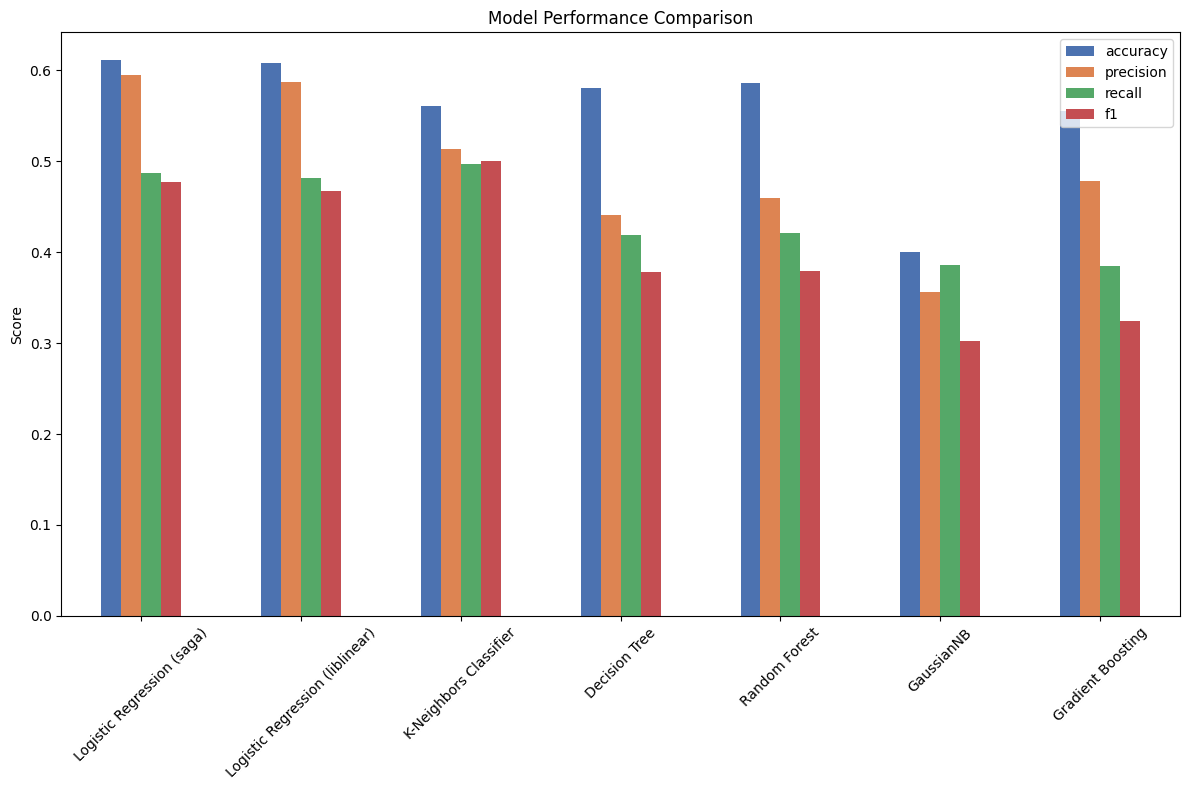

In [22]:
metrics_df = pd.DataFrame(results).T
metrics_df[['accuracy', 'precision', 'recall', 'f1']].plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

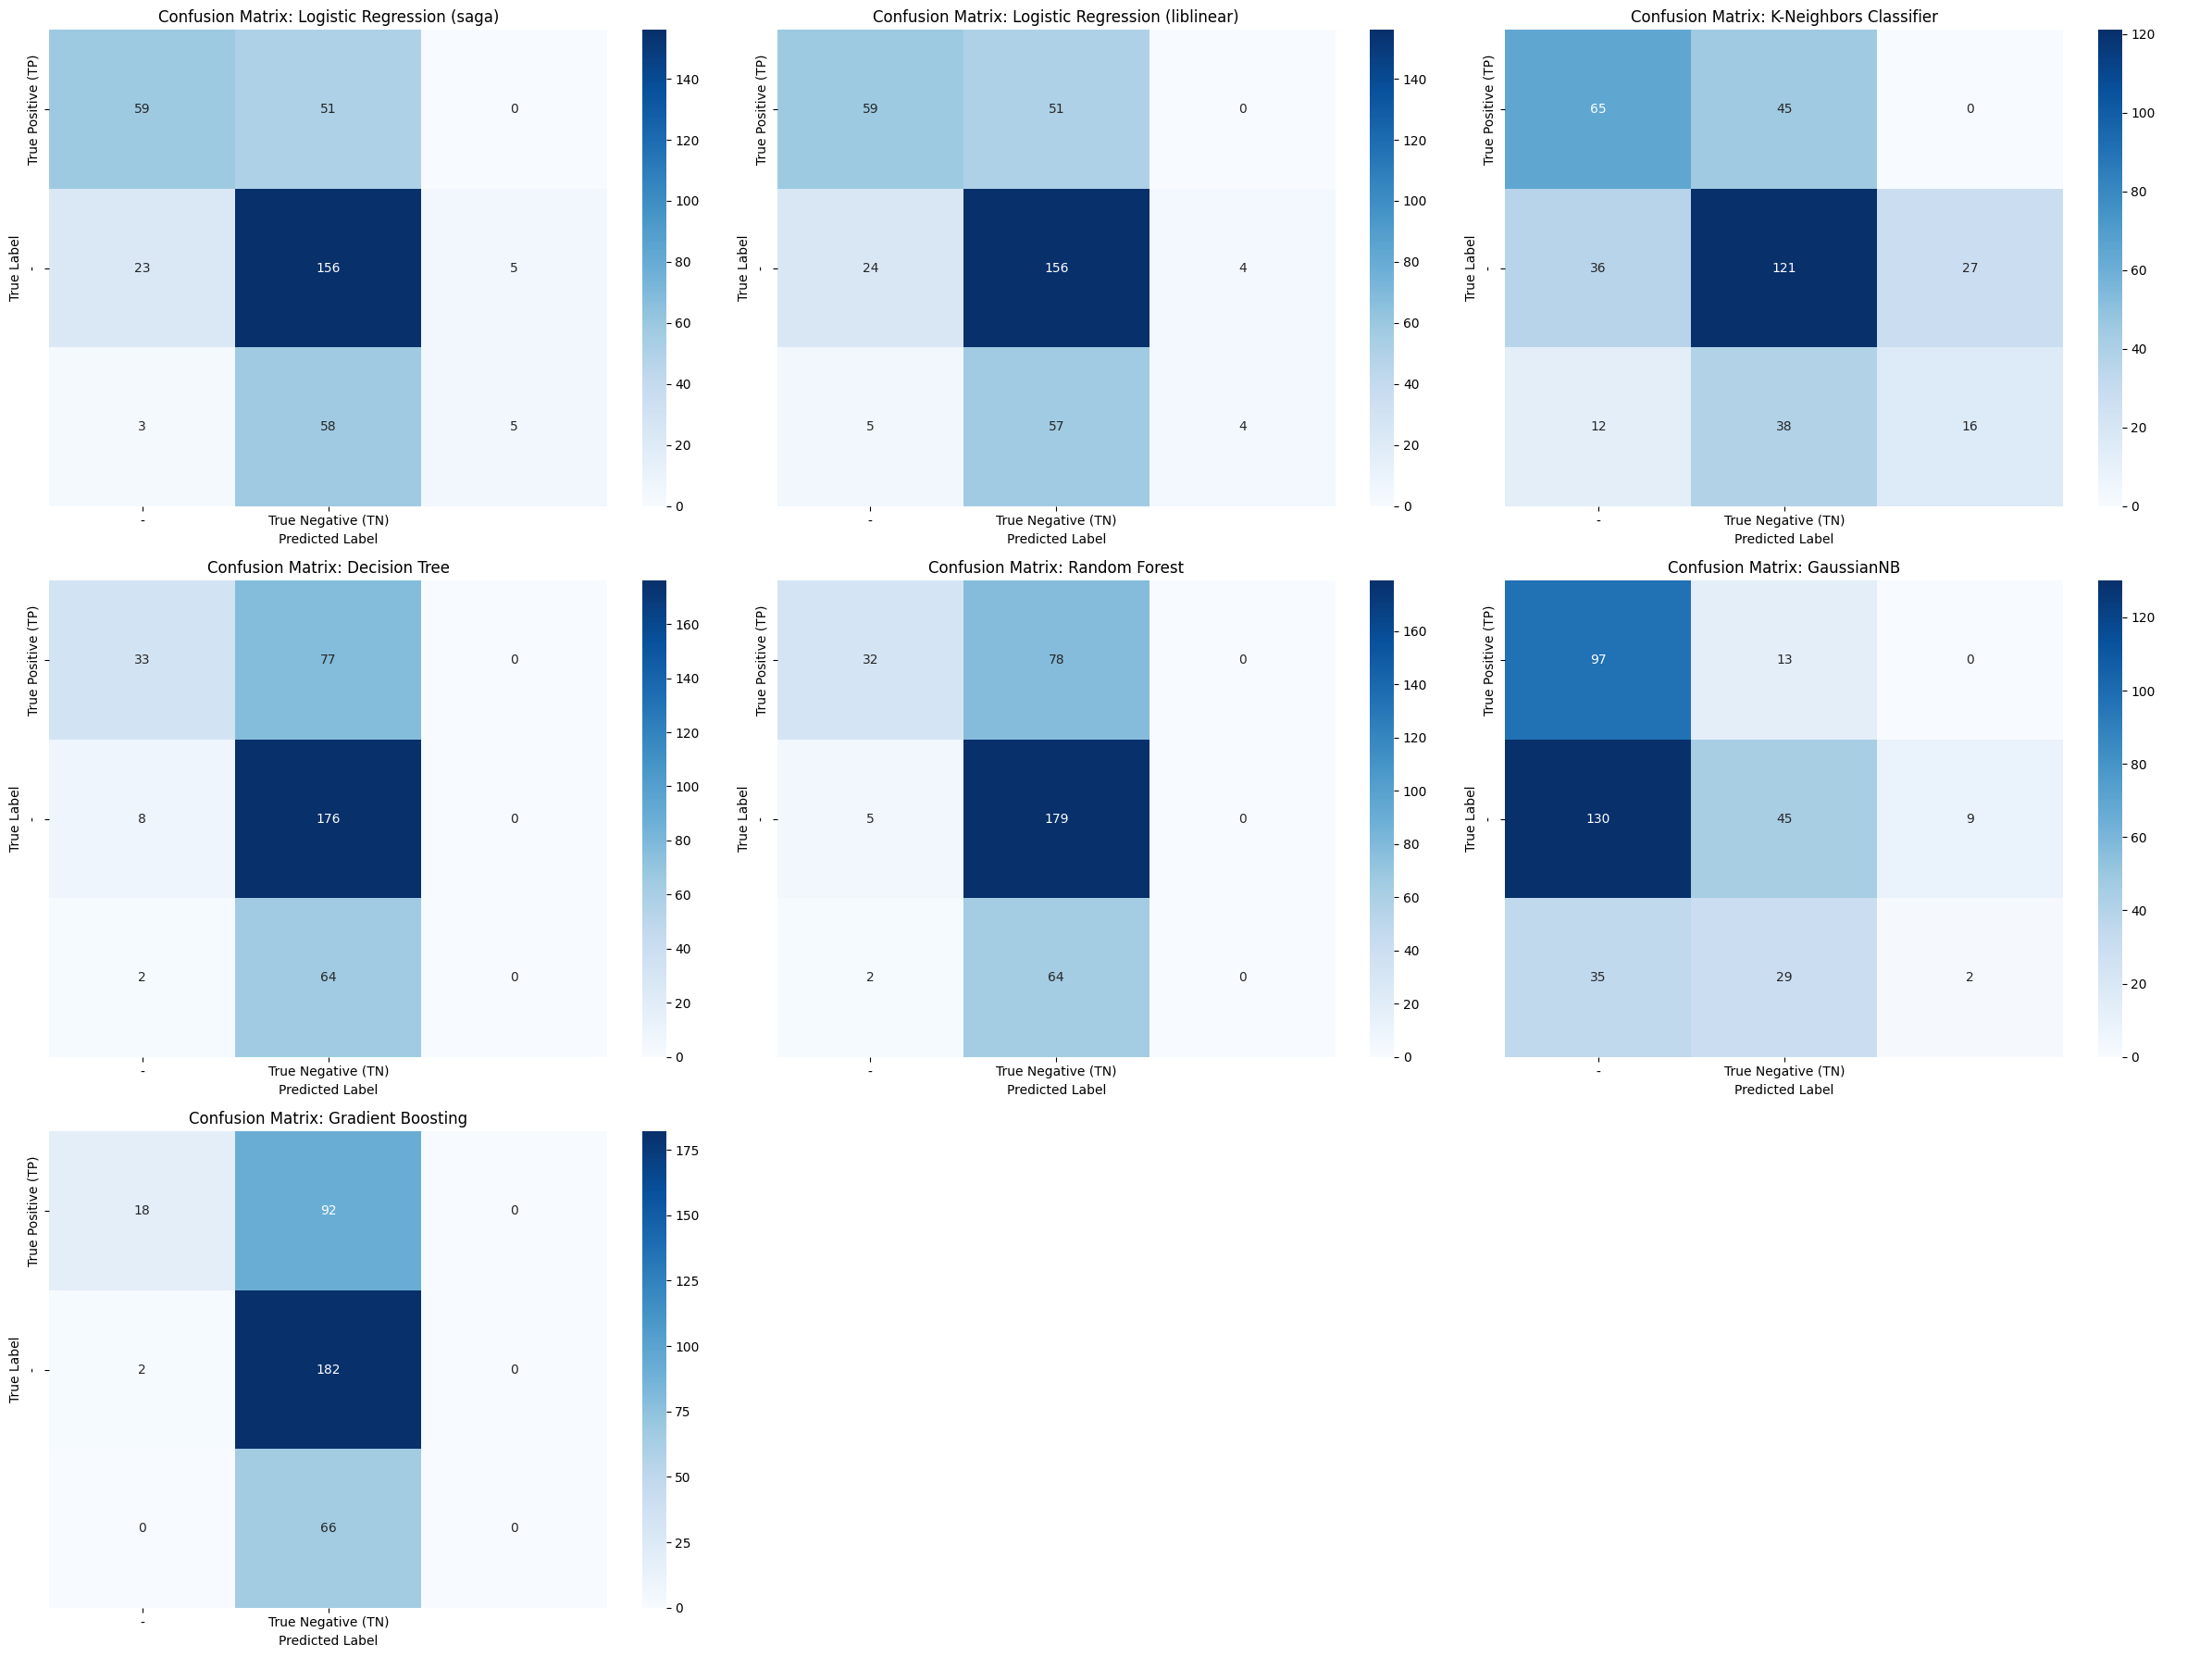

In [23]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
axes = axes.flatten()
labels = ['-', 'True Negative (TN)', 'True Positive (TP)', '-']
for i, model_name in enumerate(models.keys()):
    cm = results[model_name]['confusion_matrix']
    cm_reshaped = cm.reshape(3, 3)
    sns.heatmap(cm_reshaped, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels[:2], yticklabels=labels[2:], ax=axes[i])  
    axes[i].set_title(f'Confusion Matrix: {model_name}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()


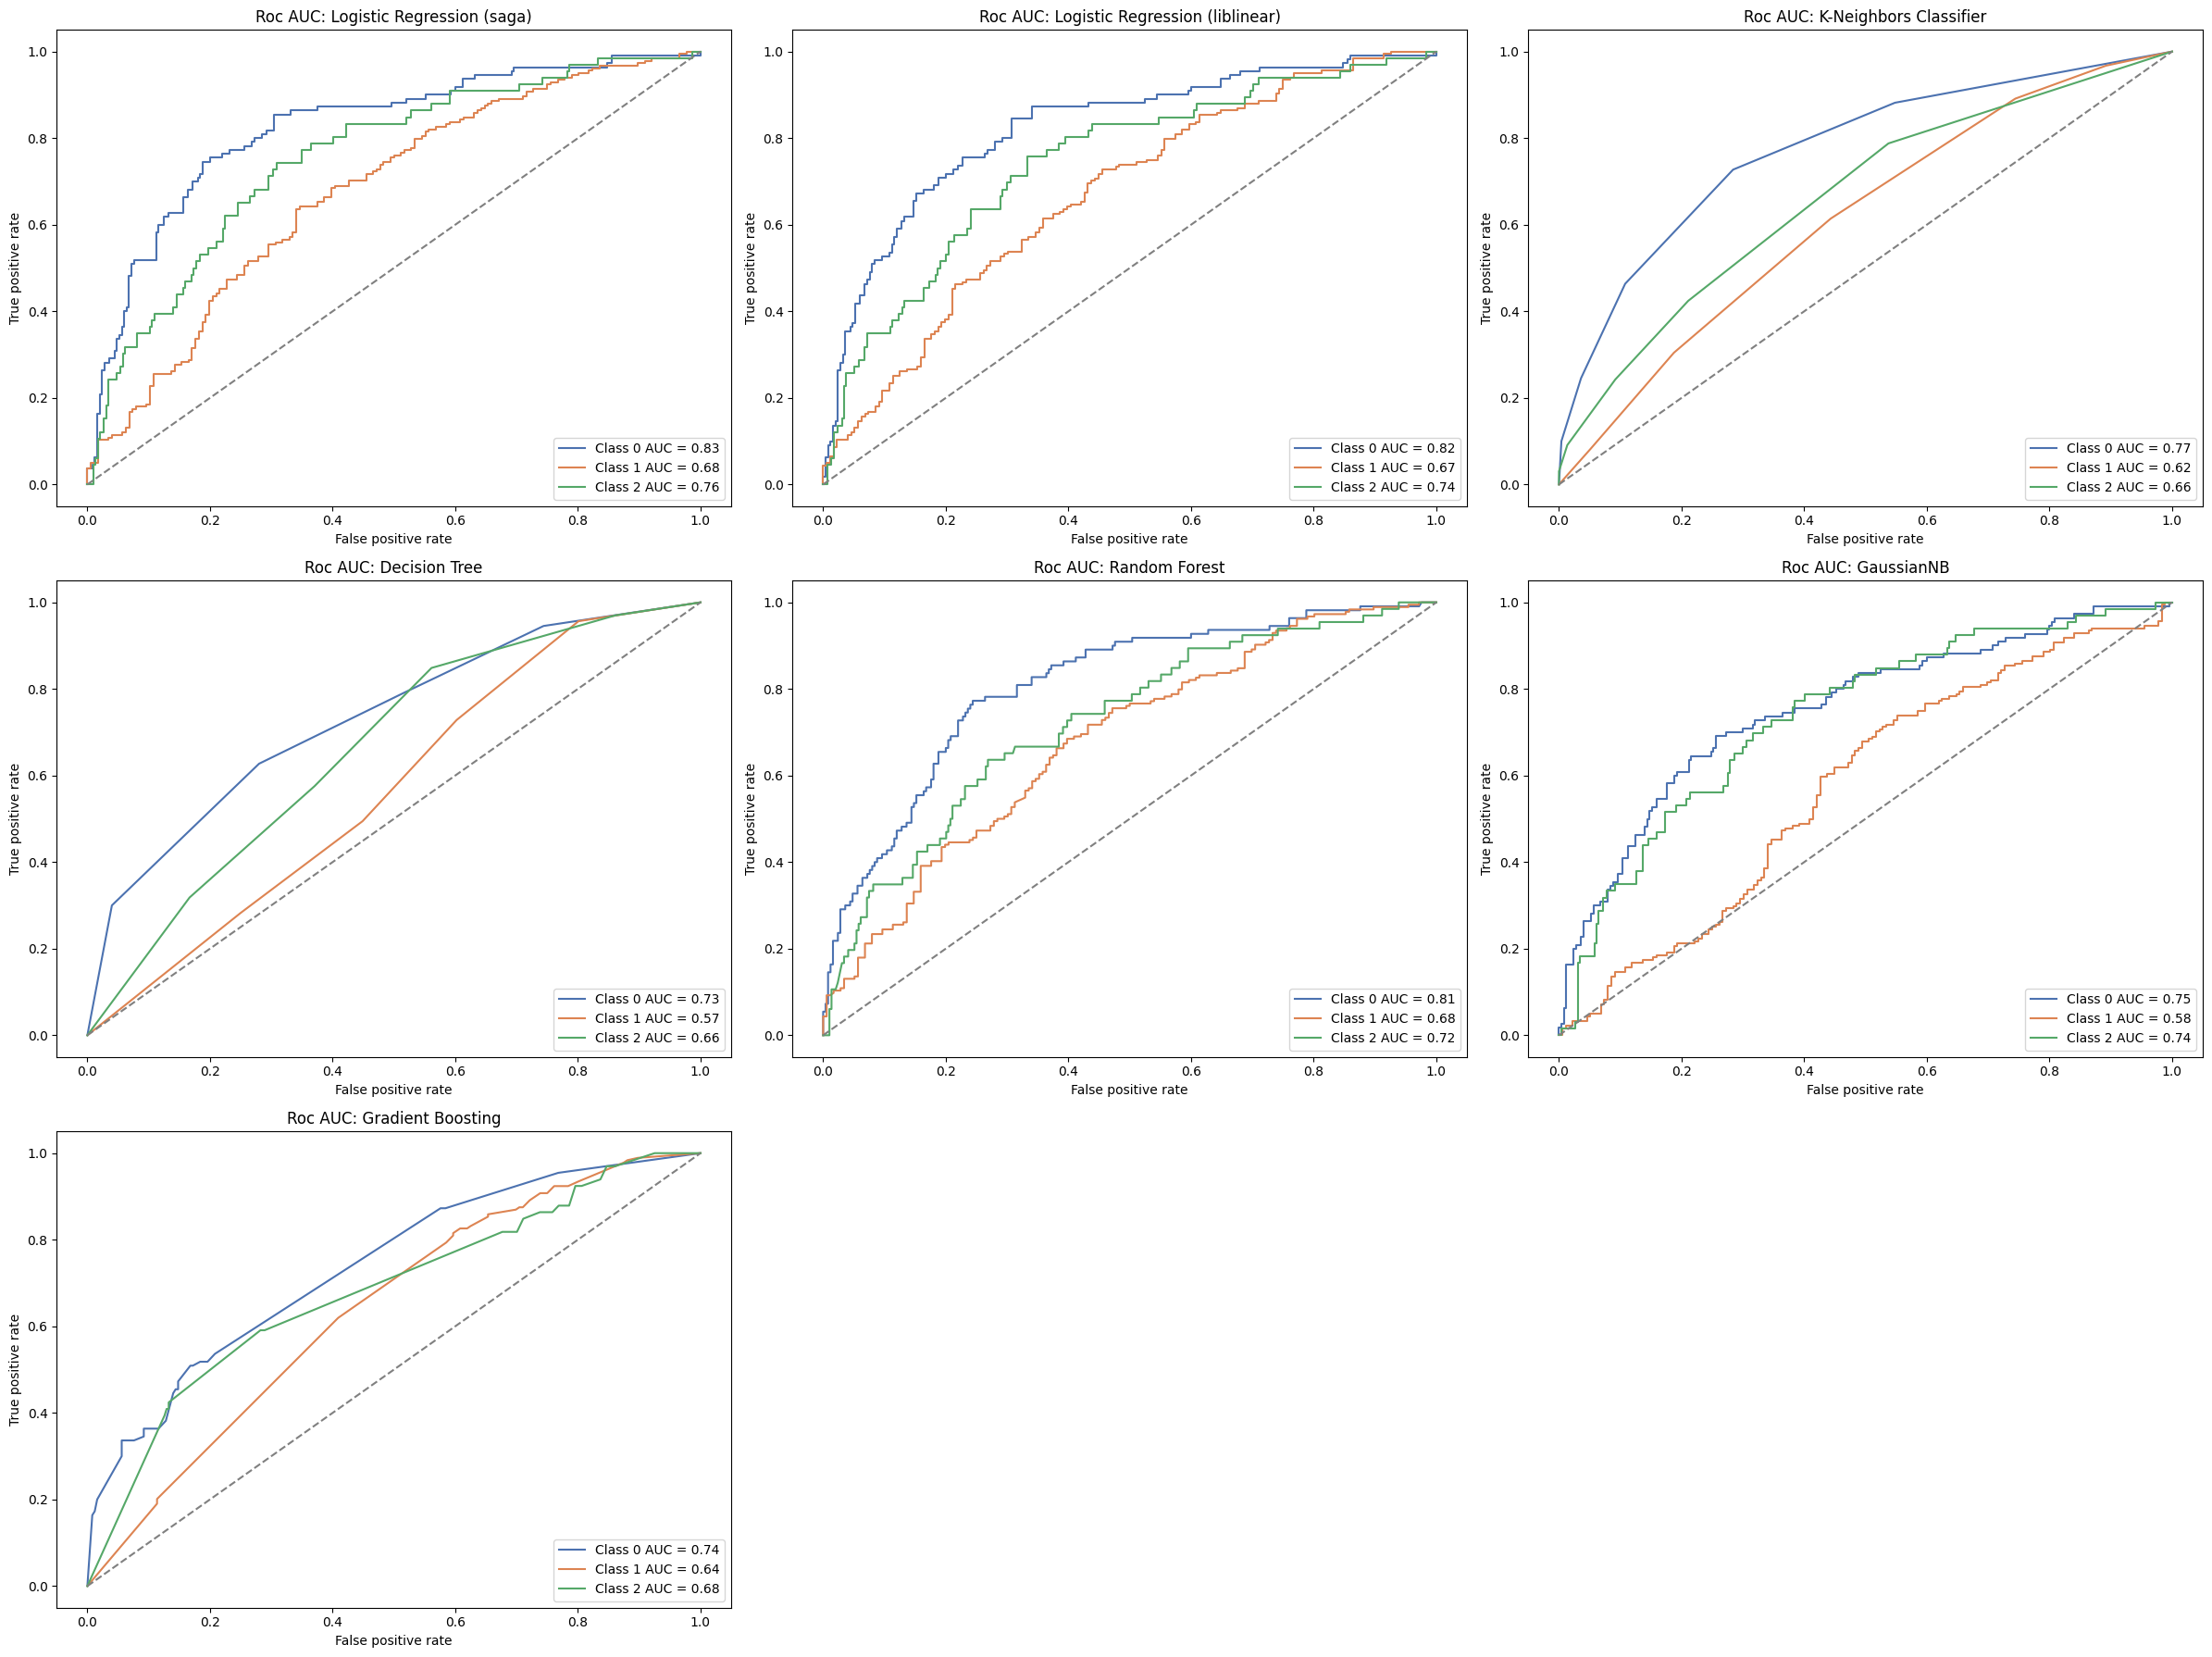

In [24]:

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
axes = axes.flatten()
for i, model_name in enumerate(models.keys()):
    fpr = results[model_name]['fpr']
    tpr = results[model_name]['tpr']
    roc_auc = results[model_name]['roc_curve']
    for j in range(n_classes):
        axes[i].plot(fpr[j], tpr[j], label=f'Class {j} AUC = {roc_auc[j]:.2f}')
    axes[i].plot([0, 1], [0, 1], color='gray', linestyle='--')
    axes[i].set_title(f'Roc AUC: {model_name}')
    axes[i].set_xlabel('False positive rate')
    axes[i].set_ylabel('True positive rate')
    axes[i].legend(loc='lower right')
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()


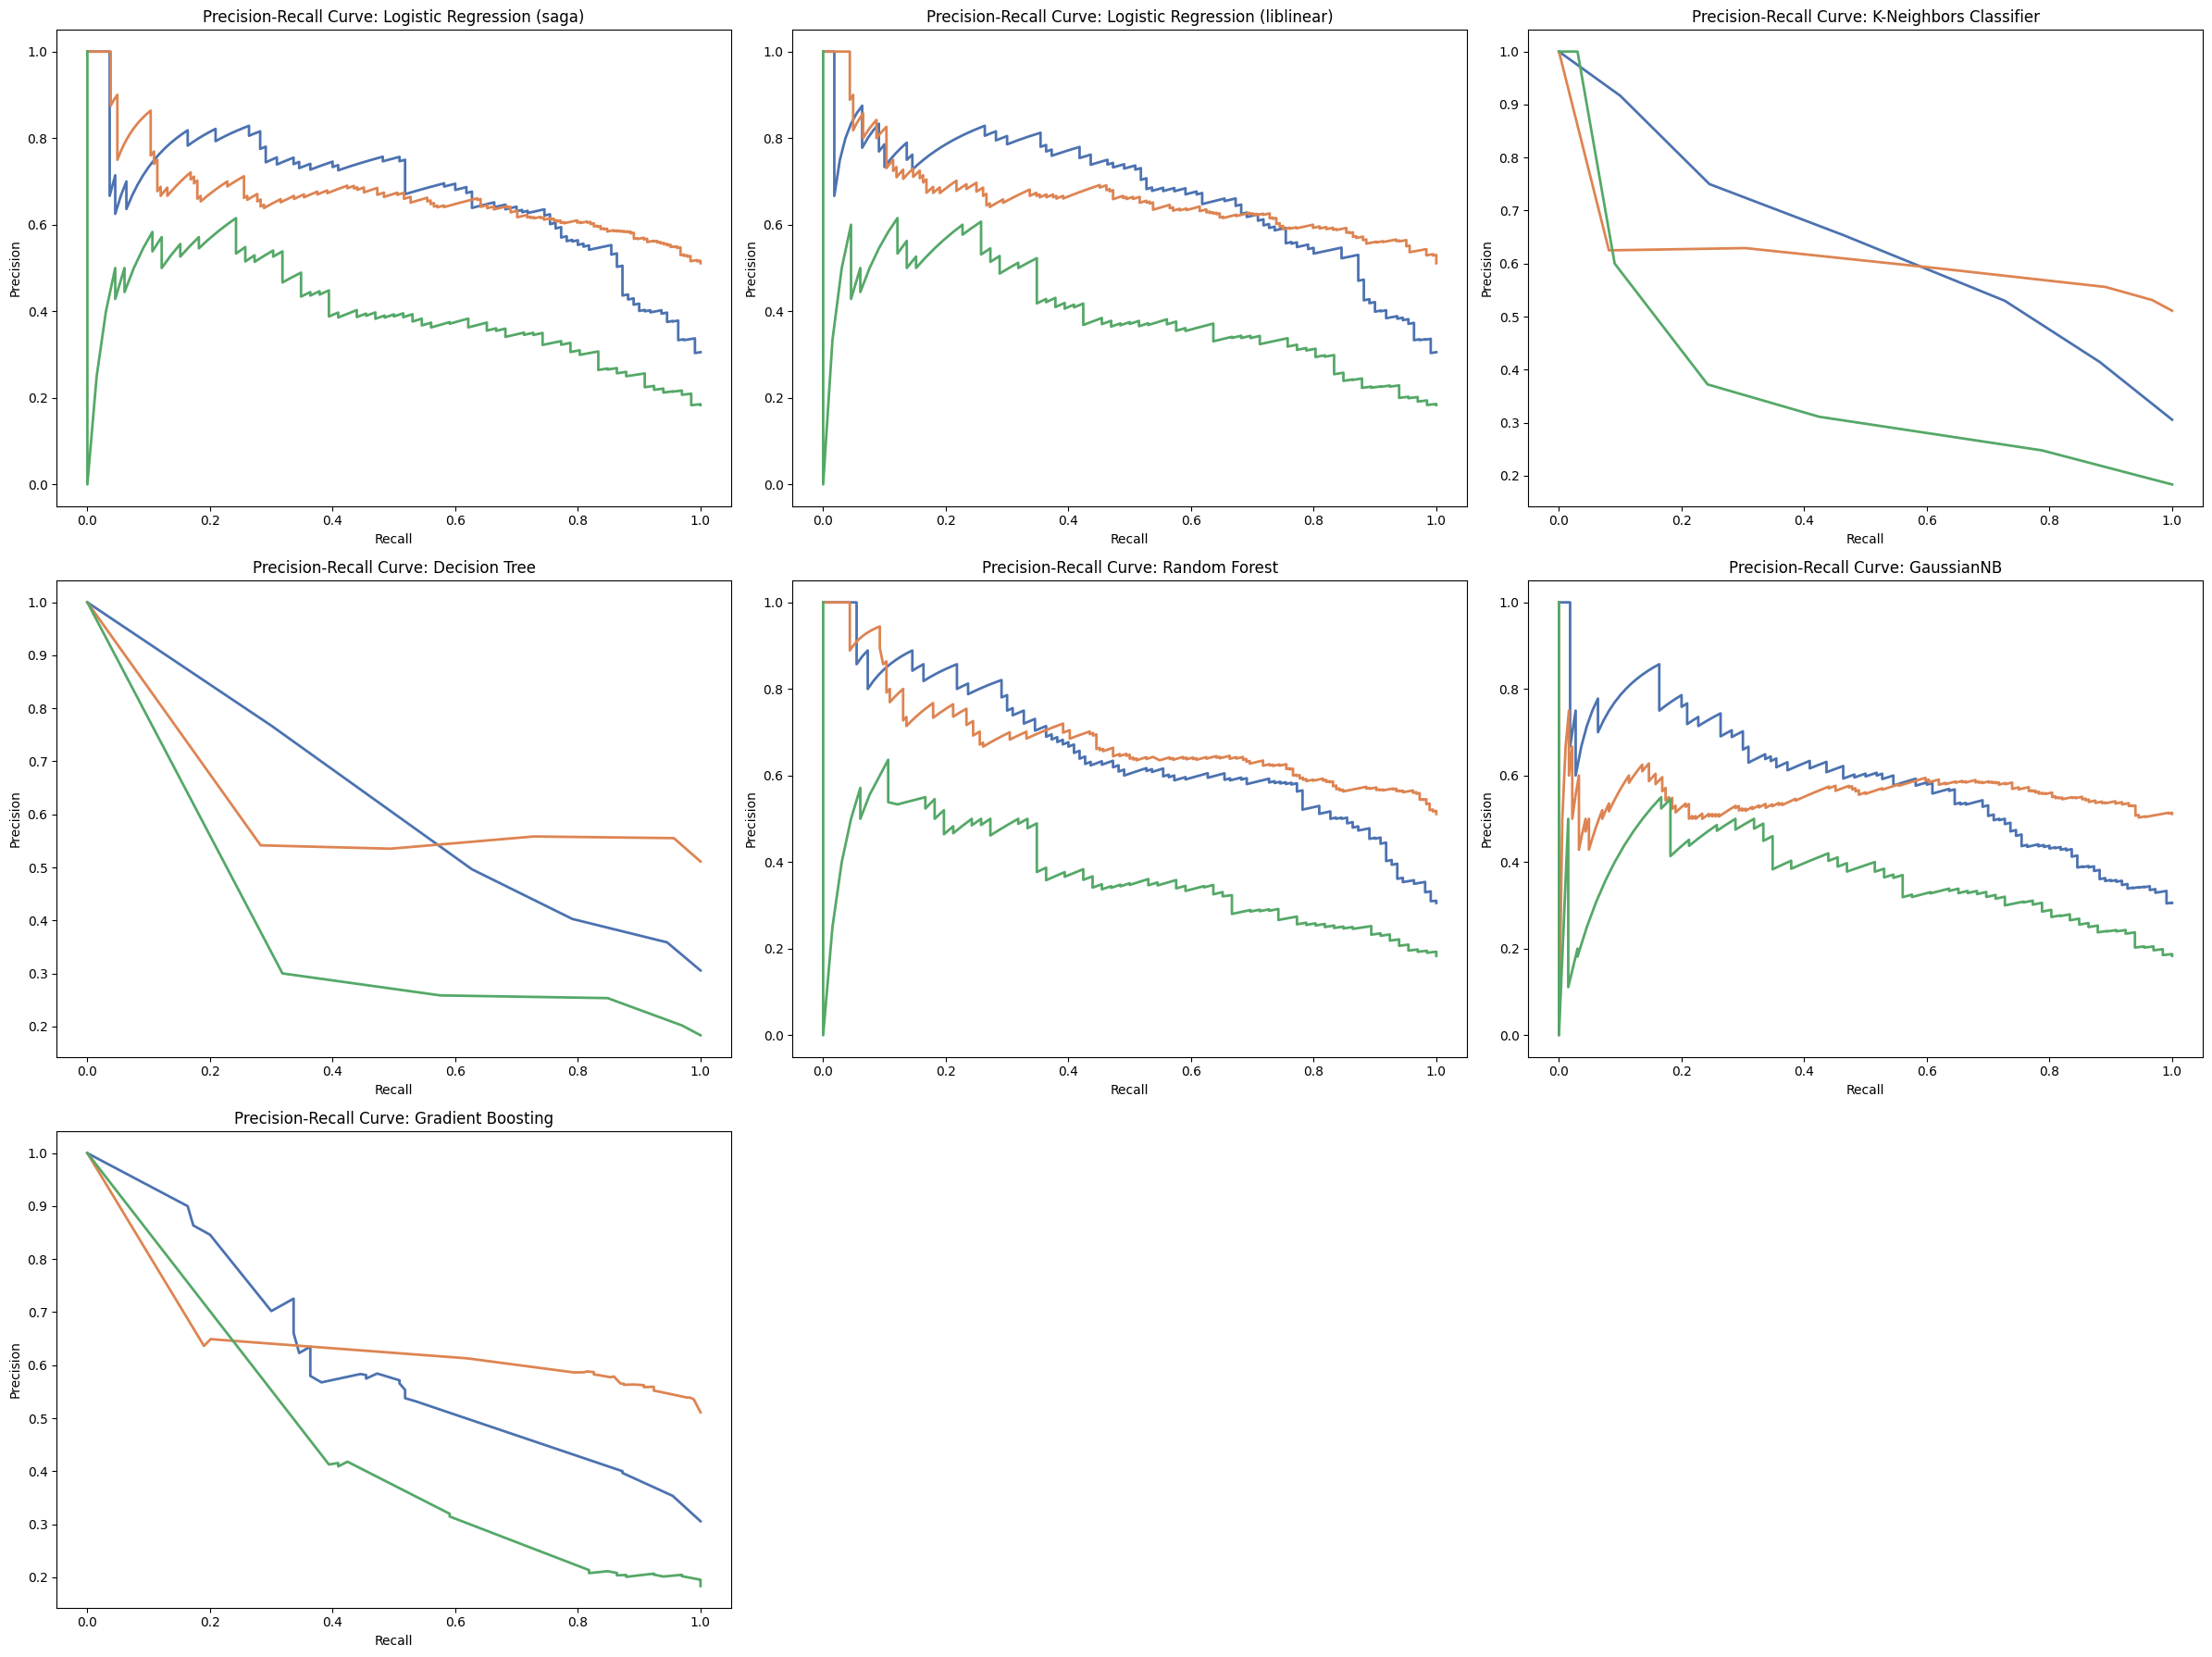

In [25]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
axes = axes.flatten()
for i, model_name in enumerate(models.keys()):
    recall = results[model_name]['recall_curve']
    precision = results[model_name]['precision_curve']
    for j in range(n_classes):
        axes[i].plot(recall[j], precision[j], lw=2)
    axes[i].set_title(f'Precision-Recall Curve: {model_name}')
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

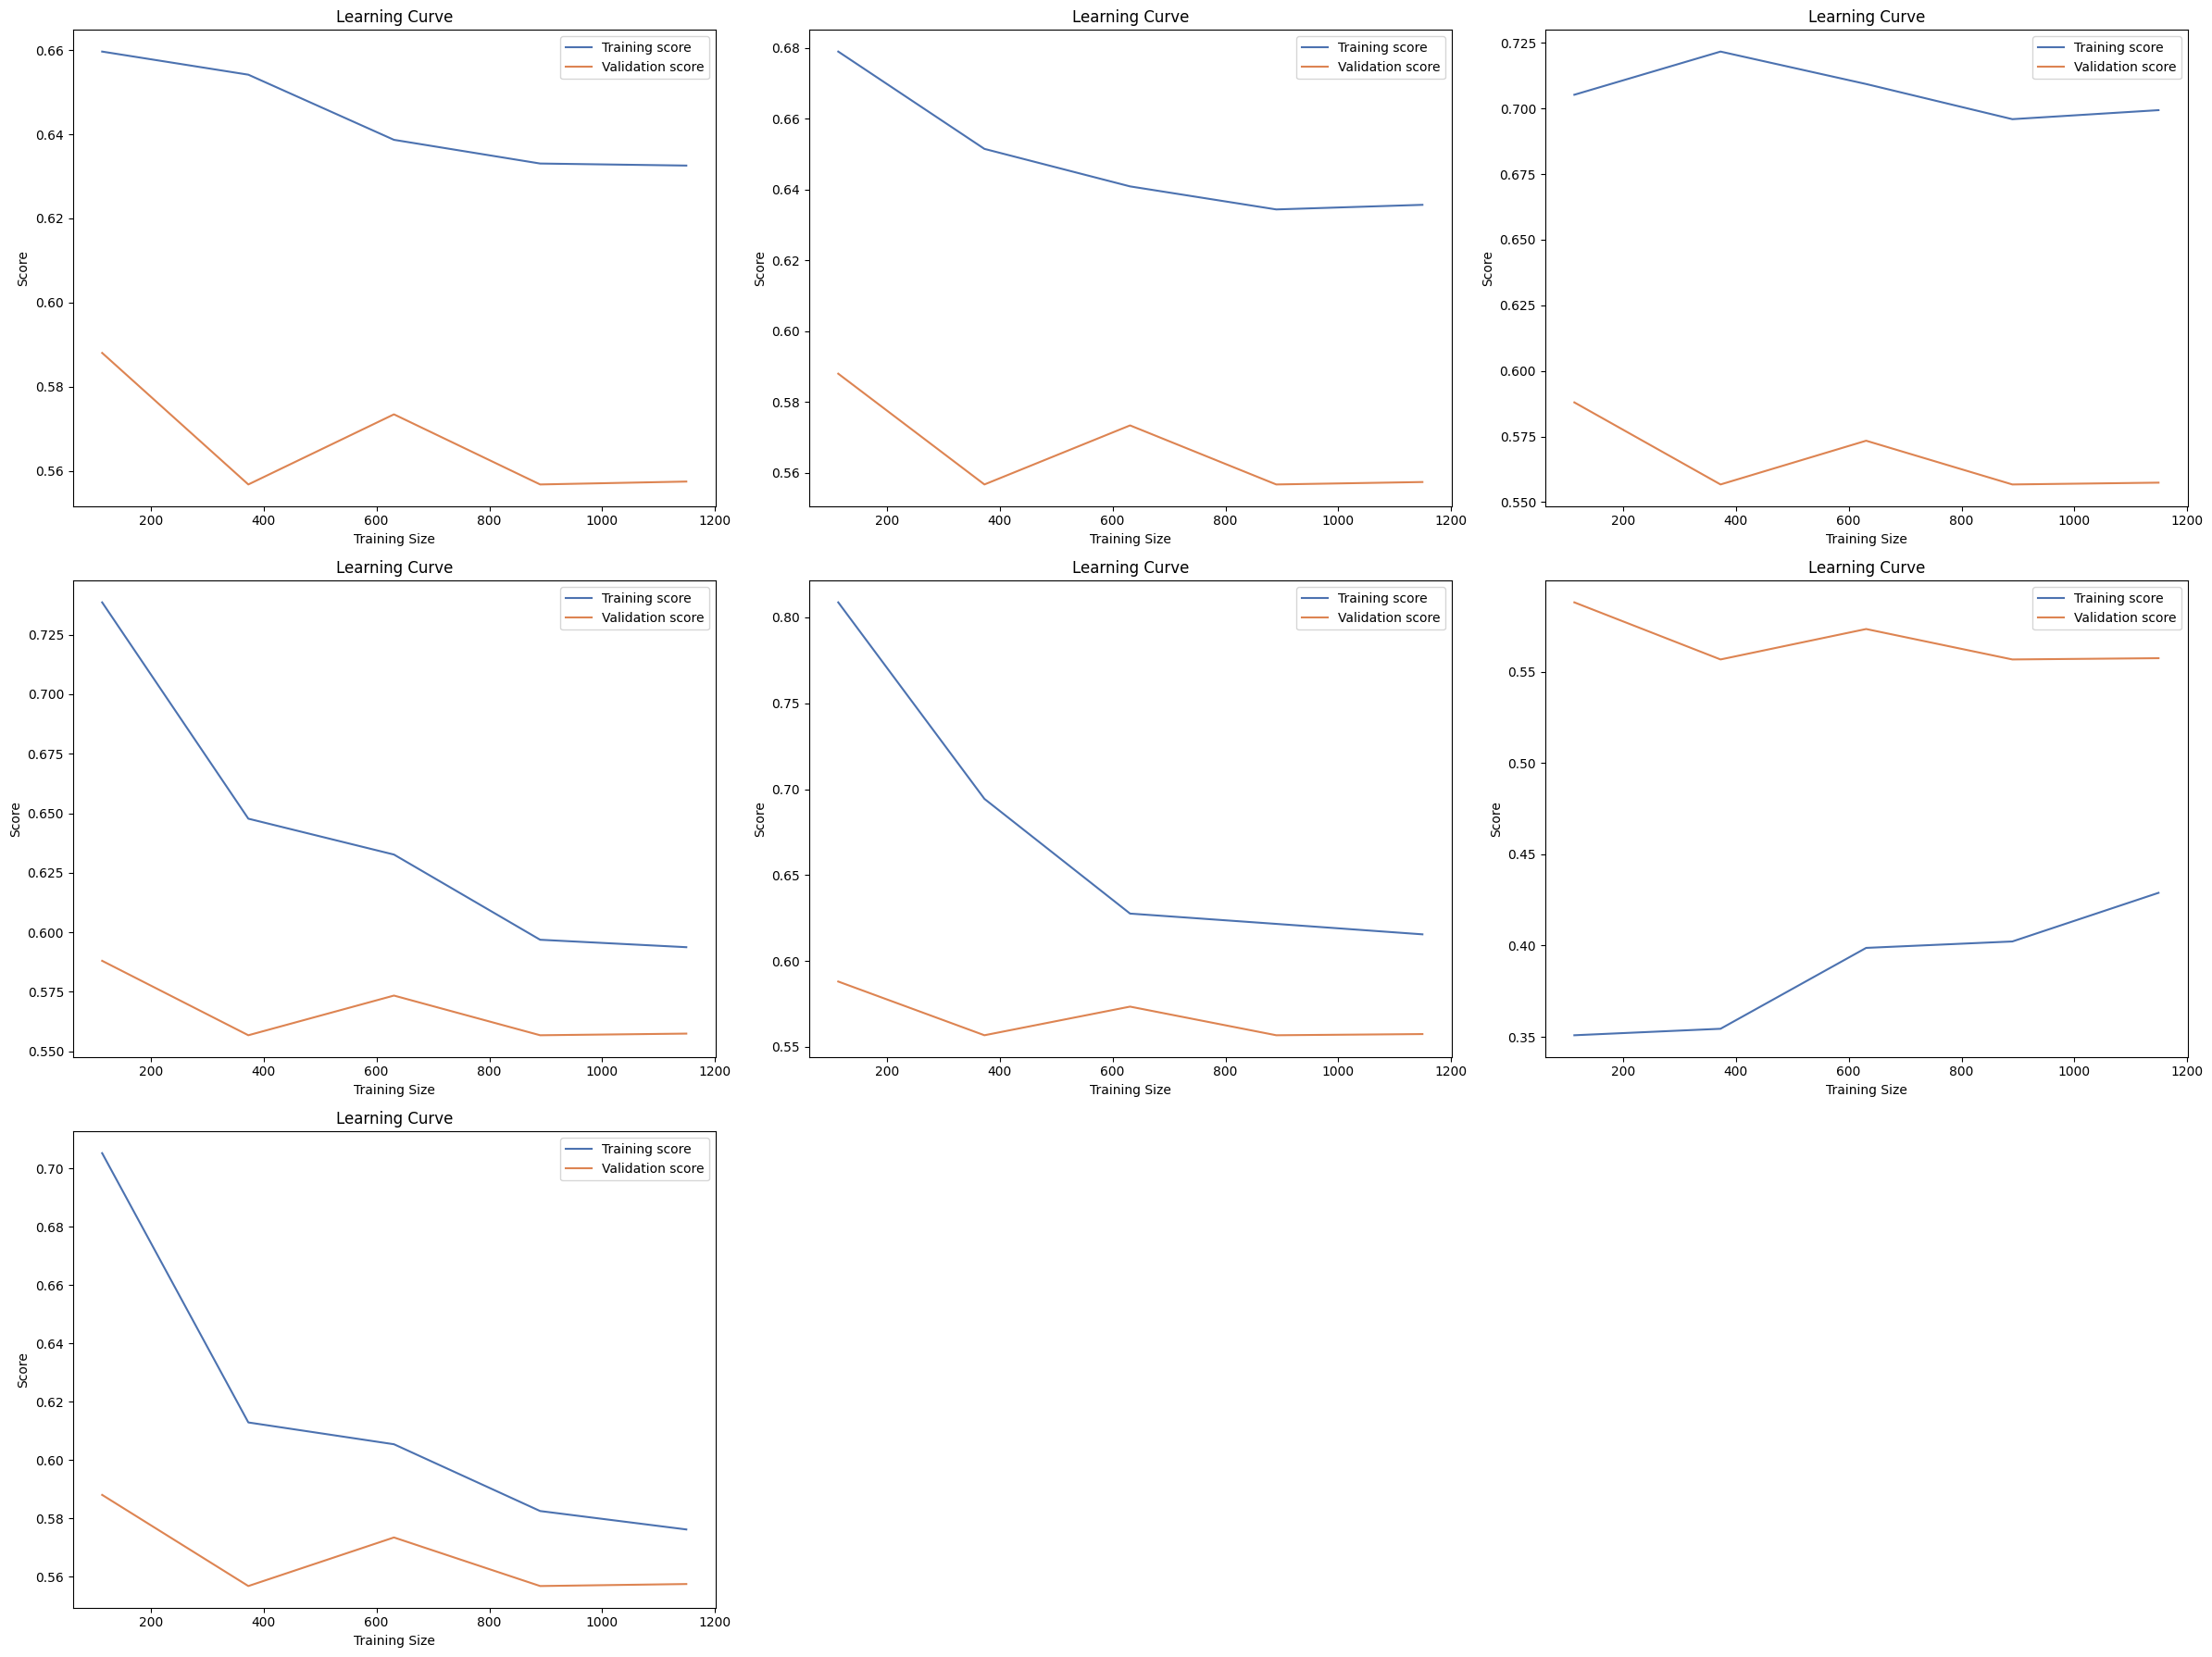

In [26]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
axes = axes.flatten()
for i, model_name in enumerate(models.keys()):
    train_size = results[model_name]['train_sizes']
    train_scores = results[model_name]['train_scores']
    valid_scores = results[model_name]['validation_scores']
    param_range = np.arange(1, 10, 1)
    axes[i].plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
    axes[i].plot(train_sizes, np.mean(validation_scores, axis=1), label='Validation score')
    axes[i].set_title('Learning Curve')
    axes[i].set_xlabel('Training Size')
    axes[i].set_ylabel('Score')
    axes[i].legend()
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

### After trial and error, we've reached final model - Logistic Regression with liblinear solver. Even though other models perfomed quite similar to each other and showed similar scorings. (investigate why this model performed the best with such solver, is it our dataset or not enough data to make others work?)